In [1]:
%matplotlib inline

import sys
import time
import math
import outliers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn import svm

import multiprocessing
import tempfile
import os
from joblib import Parallel, delayed
from joblib.pool import has_shareable_memory
cpuN = multiprocessing.cpu_count()

import warnings
warnings.filterwarnings('ignore')

prescription = pd.read_csv('data/prescriptions2017_clean.csv.gz', compression='gzip')

In [2]:
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.mixture import GaussianMixture
from sklearn.svm import OneClassSVM

def computeCLF(X,Y,epsilon,scores,clf_name):
    
    classifiers = {
        "SVM": OneClassSVM(nu=epsilon, gamma=4),
        "Cov": EllipticEnvelope(contamination=epsilon),
        "IsoF": IsolationForest(contamination=epsilon),
        "LOF": LocalOutlierFactor(n_neighbors=500, contamination=epsilon),
        "DDC-C": outliers.ddc_outlier(alpha=epsilon,metric='cosine'),
        "DDC-J": outliers.ddc_outlier(alpha=epsilon,metric='jaccard'),
        "DDC-H": outliers.ddc_outlier(alpha=epsilon,metric='hamming'),
        "DDC-M": outliers.ddc_outlier(alpha=epsilon,metric='mahalanobis'),
        "Gau": outliers.GaussianMixtureOutlier(alpha=epsilon),
    }
    
    try:
        clf = classifiers[clf_name]
        if clf_name == 'LOF':
            y_pred = clf.fit_predict(X)
        else:
            clf.fit(X)
            y_pred = clf.predict(X)

        y_pred[y_pred == 1] = 0
        y_pred[y_pred == -1] = 1
        f = f1_score(y_pred, Y)
        scores[int(epsilon*100)] = f
    except:
        scores[int(epsilon*100)] = 0

In [3]:
folder = tempfile.mkdtemp()
score_name = os.path.join(folder, 'score')

classifiers = {
    "Cov": np.arange(0.01,0.5,0.01),
    "LOF": np.arange(0.01,0.5,0.01),
    "IsoF": np.arange(0.01,0.5,0.01),
    "DDC-C": np.arange(0.01,1.0,0.01),
    "DDC-J": np.arange(0.01,1.0,0.01),
    "DDC-H": np.arange(0.01,1.0,0.01),
    "DDC-M": np.arange(0.01,1.0,0.01),
    "Gau": np.arange(0.01,1.0,0.01),
    "SVM": np.arange(0.01,1.0,0.01),
}

mean_ep = pd.DataFrame()
mean_f = pd.DataFrame()

med = 'ANLODIPINO 10 mg CP' #X
#med = 'DICLOFENACO 50 mg CP' X
#med = 'AMPICILINA + SULBACTAM 2 g + 1 g SOL INJ' X
#med = 'VARFARINA 5 mg CP' # V
#med = 'HIOSCINA (BUTILBROMETO DE ESCOPOLAMINA) 20 mg/ml SOL INJ' # V
#med = 'TRAMADOL 50mg/ml 1ml SOL INJ'
#med = 'VITAMINAS DO COMPLEXO B CP' X

X, Y = outliers.getPrescriptions(prescription, med)
anomalies = len(Y[Y==1])
total = len(X)

print(med + ', Size: ', total, ' Overdose: ', anomalies)

for i, (clf_name, ep_range) in enumerate(classifiers.items()):

    print(clf_name)
    
    index_list = np.append([], [])
    skf = StratifiedKFold(n_splits=anomalies)
    div = 1
    for train_index, test_index in skf.split(X, Y):
        
        scores_df = pd.DataFrame()
        
        index_list = np.append(index_list.astype(int), test_index.astype(int))
        size = len(index_list)
        
        X_train = X[index_list]
        Y_train = Y[index_list]
        overdose_size = len(Y_train[Y_train==1])
        
        if (size // 100) < div:
            continue
            
        size_idx = div * 100
        div = 1 + (size // 100)
        
        sys.stdout.write(str(overdose_size) + '/' + str(size) +', ')
        
        scores = np.memmap(score_name, dtype=float, shape=(150), mode='w+')
        
        Parallel(n_jobs=cpuN)(delayed(computeCLF)(X_train, Y_train,epsilon,scores,clf_name)
                   for epsilon in ep_range)
        
        for ep in ep_range:
            idx = int(ep*100)
            scores_df.loc[clf_name,ep] = scores[idx]
        
        ep_max = scores_df.loc[clf_name].idxmax()
        mean_ep.loc[clf_name,size_idx] = float(ep_max)
        mean_f.loc[clf_name,size_idx] = scores_df.loc[clf_name].max()
        
        sys.stdout.write('('  + str(ep_max) + ',' + str(scores_df.loc[clf_name].max()) +') ')
        
        if size > 5000:
            break

    print('')

print('Done')
mean_ep

ANLODIPINO 10 mg CP, Size:  15584  Overdose:  268
DDC-C
2/118, (0.95,1.0) 4/236, (0.95,1.0) 6/354, (0.47,0.909090909091) 7/413, (0.47,0.923076923077) 9/531, (0.47,0.941176470588) 11/649, (0.47,0.952380952381) 12/708, (0.47,0.95652173913) 14/826, (0.47,0.962962962963) 16/944, (0.47,0.967741935484) 17/1003, (0.47,0.969696969697) 19/1121, (0.47,0.972972972973) 21/1239, (0.47,0.952380952381) 23/1357, (0.47,0.95652173913) 24/1416, (0.47,0.958333333333) 26/1534, (0.47,0.961538461538) 28/1652, (0.47,0.964285714286) 29/1711, (0.47,0.965517241379) 31/1829, (0.47,0.967741935484) 33/1947, (0.47,0.969696969697) 34/2006, (0.47,0.970588235294) 36/2124, (0.47,0.972222222222) 38/2242, (0.47,0.973684210526) 39/2301, (0.47,0.974358974359) 41/2418, (0.47,0.975609756098) 43/2534, (0.47,0.976744186047) 45/2650, (0.47,0.977777777778) 46/2708, (0.47,0.978260869565) 48/2824, (0.47,0.979166666667) 50/2940, (0.47,0.98) 52/3056, (0.47,0.980769230769) 53/3114, (0.47,0.981132075472) 55/3230, (0.47,0.981818181818) 

2/118, (0.01,0.0333333333333) 4/236, (0.01,0.0333333333333) 6/354, (0.01,0.0333333333333) 7/413, (0.01,0.0333333333333) 9/531, (0.01,0.0333333333333) 11/649, (0.01,0.0333333333333) 12/708, (0.01,0.0333333333333) 14/826, (0.01,0.0333333333333) 16/944, (0.01,0.0333333333333) 17/1003, (0.01,0.0333333333333) 19/1121, (0.01,0.0333333333333) 21/1239, (0.01,0.0333333333333) 23/1357, (0.01,0.0333333333333) 24/1416, (0.01,0.0333333333333) 26/1534, (0.01,0.0333333333333) 28/1652, (0.01,0.0333333333333) 29/1711, (0.01,0.0333333333333) 31/1829, (0.01,0.0333333333333) 33/1947, (0.01,0.0333333333333) 34/2006, (0.01,0.0333333333333) 36/2124, (0.01,0.0333333333333) 38/2242, (0.01,0.0333333333333) 39/2301, (0.01,0.0333333333333) 41/2418, (0.01,0.0333468889793) 43/2534, (0.01,0.0333721381451) 45/2650, (0.01,0.0333951762523) 46/2708, (0.01,0.0334059549746) 48/2824, (0.01,0.033426183844) 50/2940, (0.01,0.0334448160535) 52/3056, (0.01,0.033462033462) 53/3114, (0.01,0.0334701610357) 55/3230, (0.01,0.0334855

,100,200,300,400,500,600,700,800,900,1000,...,4100,4200,4300,4400,4500,4600,4700,4800,4900,5000
DDC-C,0.95,0.95,0.47,0.47,0.47,0.47,0.47,0.47,0.47,0.47,...,0.47,0.47,0.47,0.47,0.47,0.47,0.47,0.47,0.47,0.47
LOF,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
Gau,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
DDC-J,0.04,0.04,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,...,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06
DDC-H,0.95,0.95,0.94,0.94,0.94,0.94,0.94,0.94,0.94,0.94,...,0.93,0.93,0.93,0.93,0.93,0.93,0.93,0.93,0.93,0.93
SVM,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
Cov,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,0.01,0.02,0.05,0.01,0.01,0.01,0.09,0.10,0.29,0.01
DDC-M,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,0.98,0.98,0.98,0.98,0.98,0.98,0.98,0.98,0.98,0.98
IsoF,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01


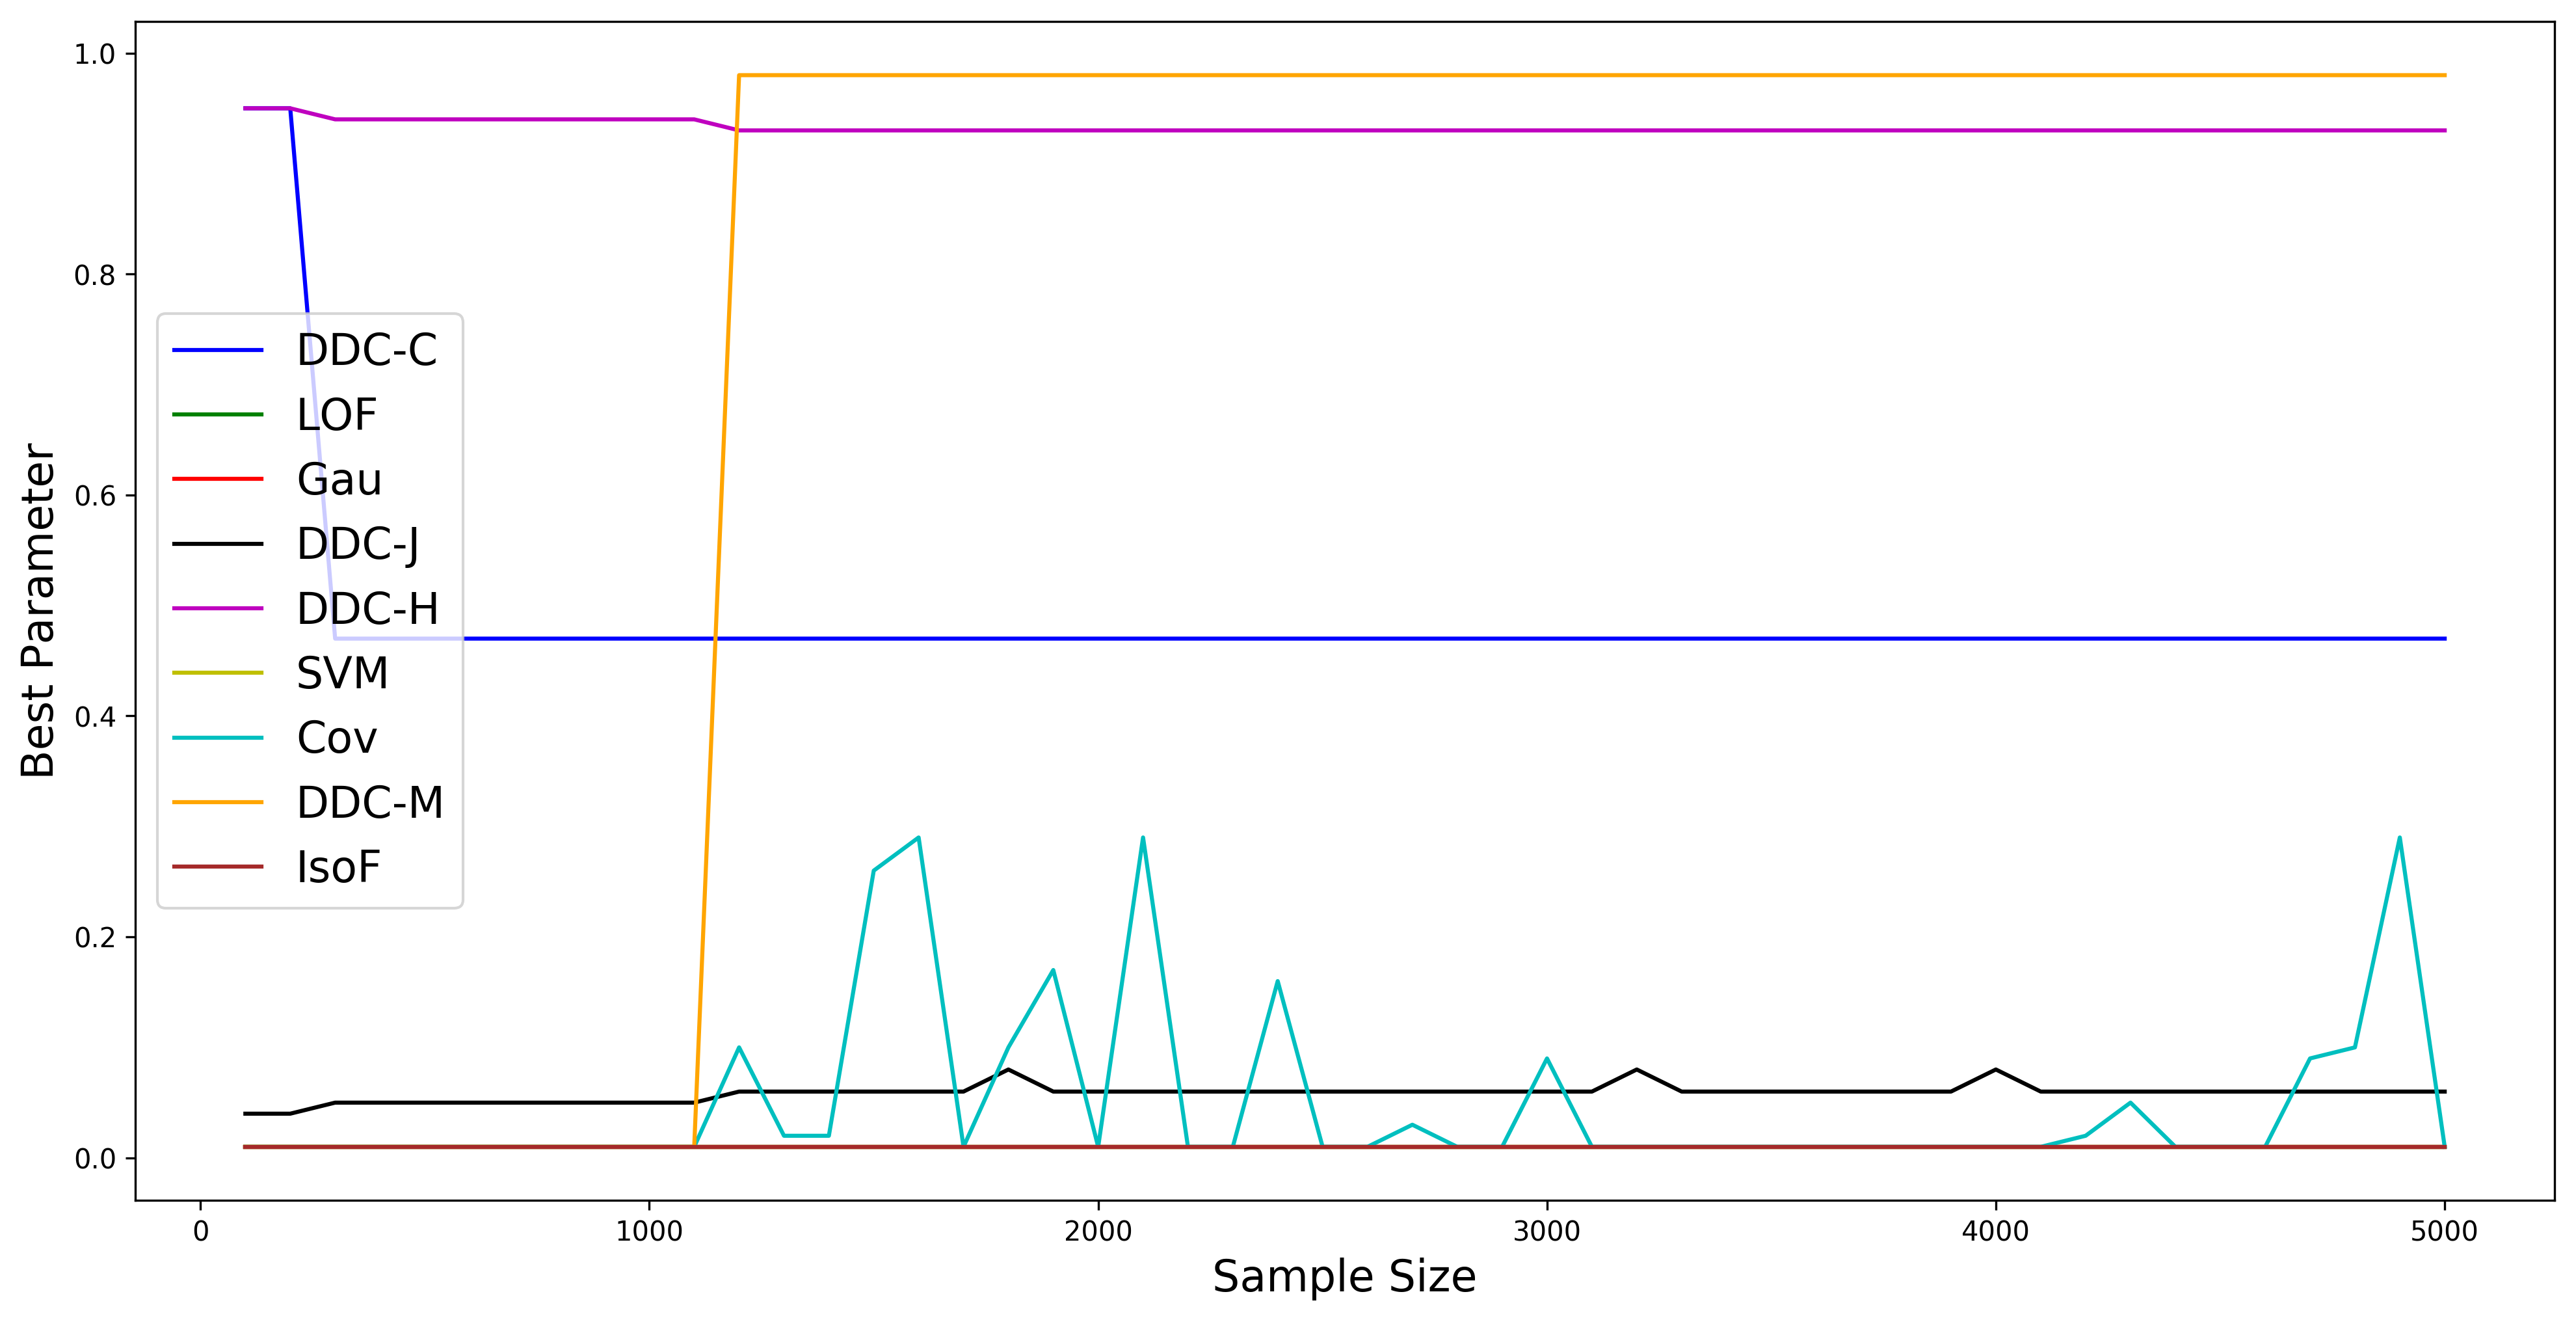

In [4]:
plt.figure(figsize=(16, 8), dpi= 300)
colors = ['b', 'g', 'r', 'k', 'm', 'y', 'c', 'orange', 'brown']
i = 0
for m in mean_ep.index:
    plt.plot(np.asarray(mean_ep.columns),np.asarray(mean_ep.loc[m].values), c=colors[i],label=m)
    i += 1
    
plt.legend(fontsize=16)
plt.xlabel('Sample Size', fontsize=16)
plt.ylabel('Best Parameter', fontsize=16)
#plt.ylim(0,22)
#plt.xlim(0,28000)
plt.show()

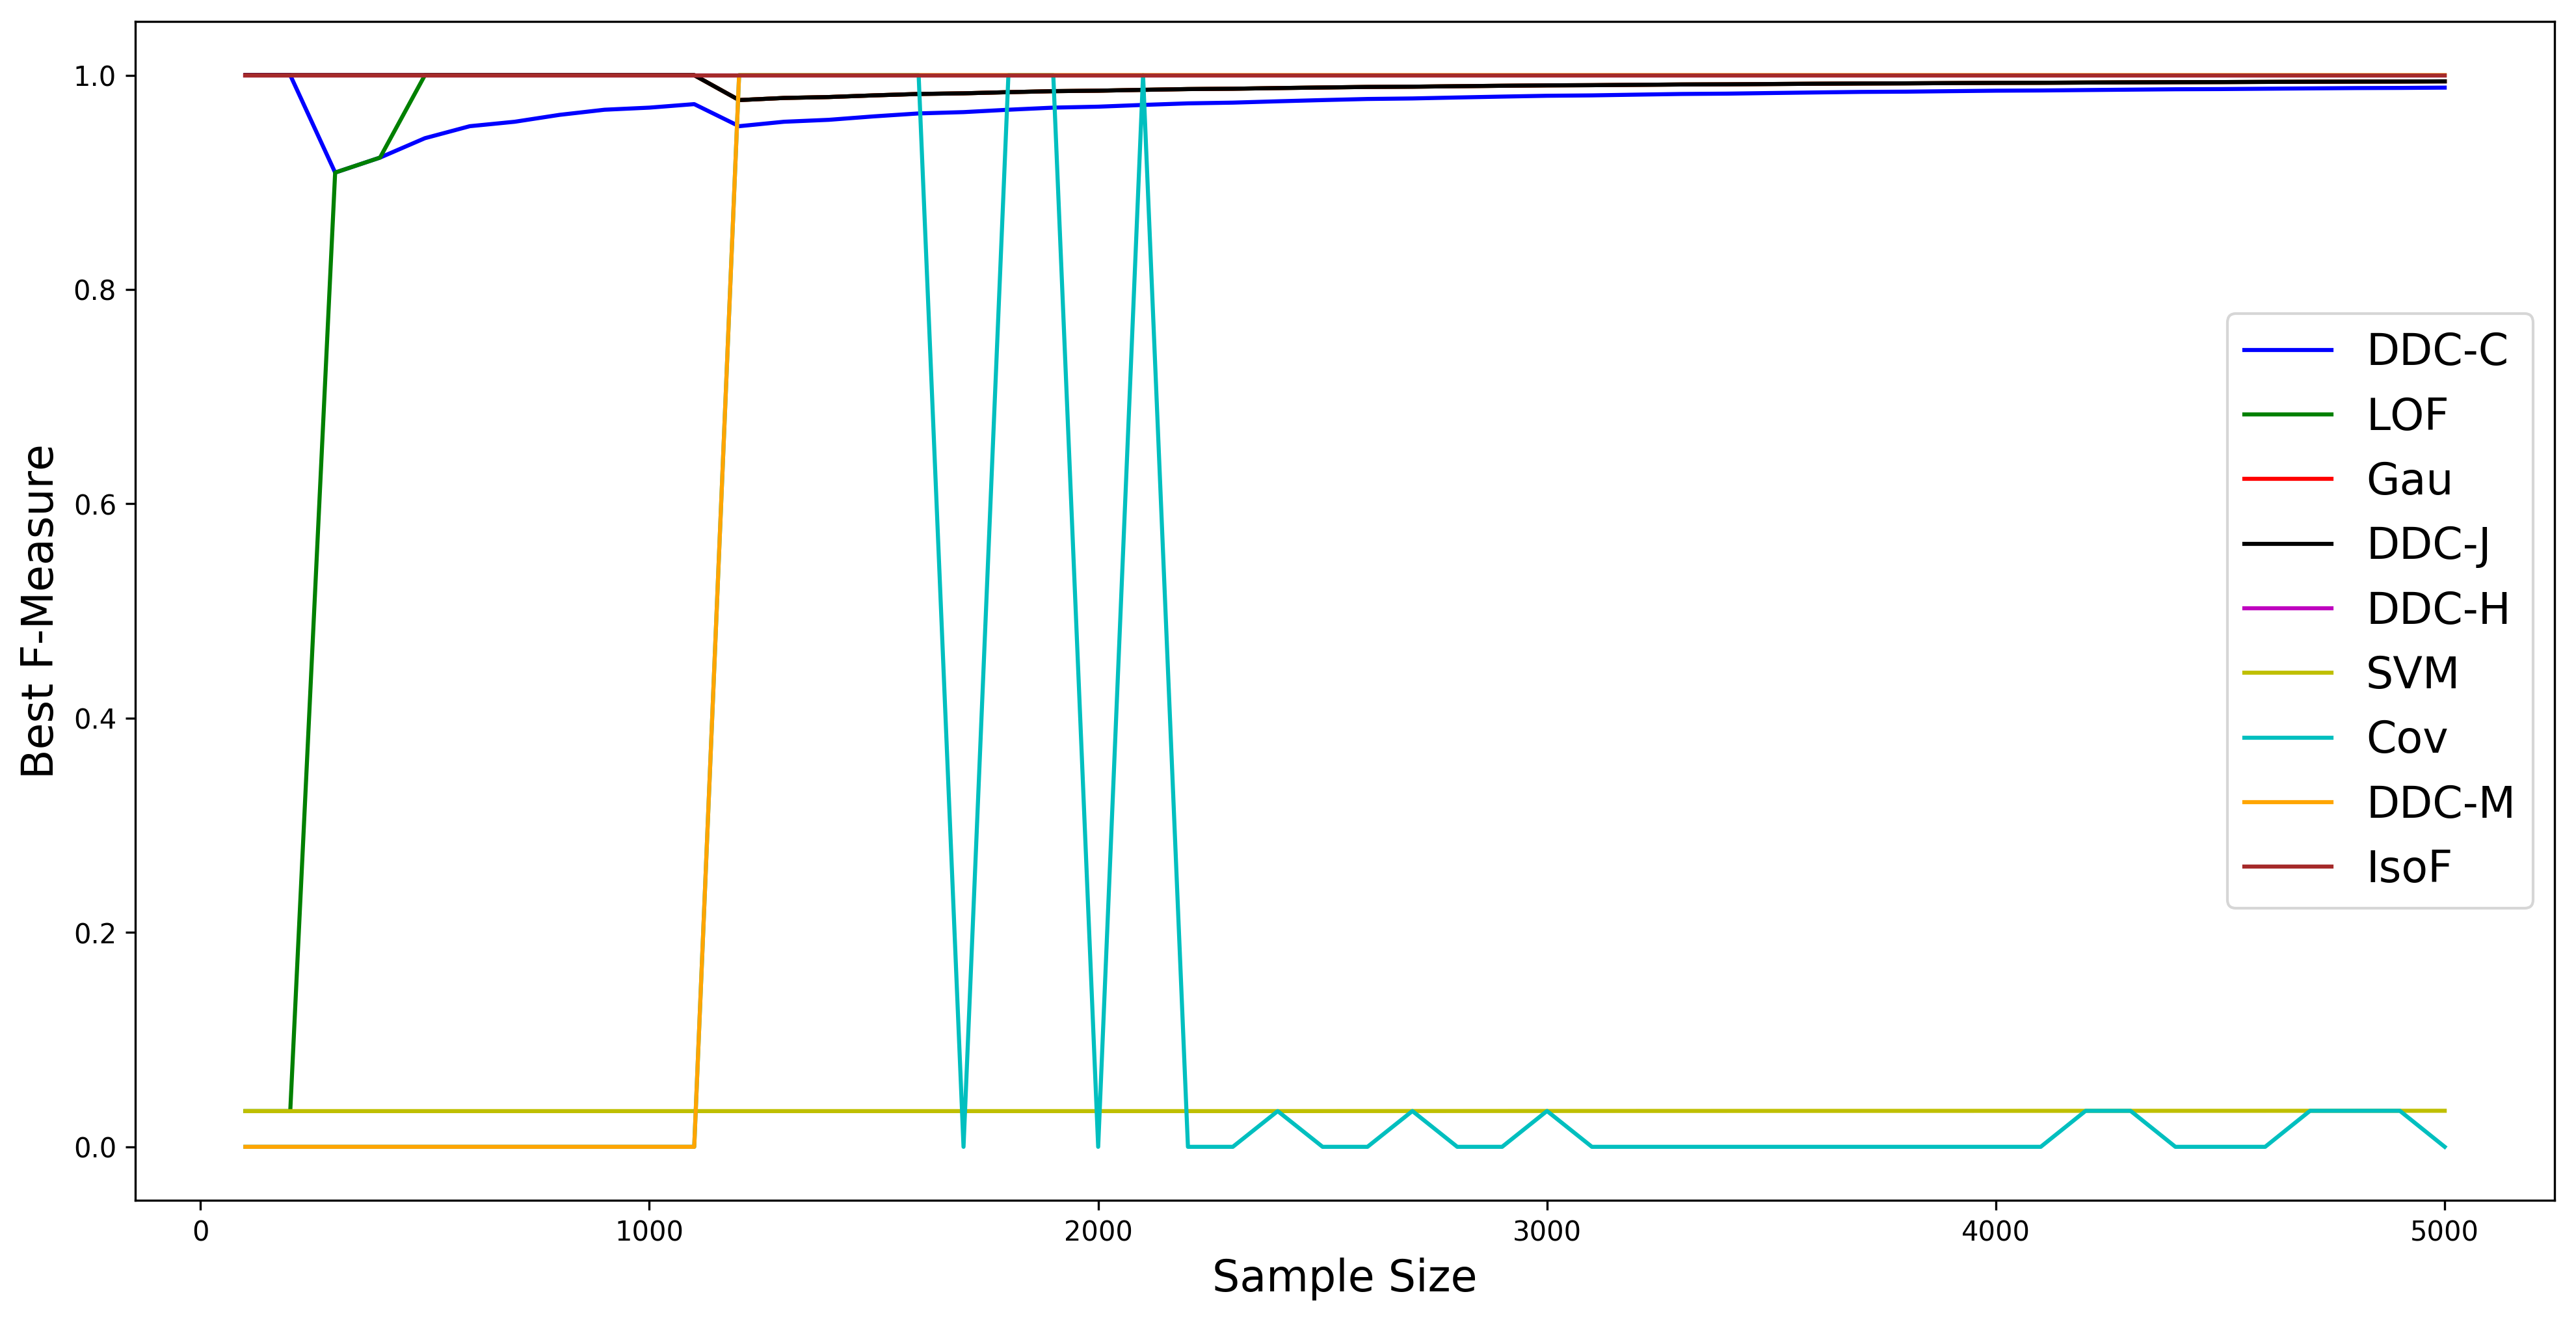

In [7]:
plt.figure(figsize=(16, 8), dpi= 300)
colors = ['b', 'g', 'r', 'k', 'm', 'y', 'c', 'orange', 'brown']
i = 0
for m in mean_f.index:
    plt.plot(np.asarray(mean_f.columns),np.asarray(mean_f.loc[m].values), c=colors[i],label=m)
    i += 1
    
plt.legend(fontsize=16)
plt.xlabel('Sample Size', fontsize=16)
plt.ylabel('Best F-Measure', fontsize=16)
#plt.ylim(0,22)
#plt.xlim(0,28000)
plt.show()